In [1]:
import pandas as pd
import numpy as np
import os
import prody
import math

from pathlib import Path
import pickle
import sys
from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

# ABPRED_DIR = Path.cwd().parent
# if ABPRED_DIR not in sys.path:
#     sys.path.append(str(ABPRED_DIR))
    
from AbPred.interface_contacts import InterfaceContacts
from AbPred.features_ic import ArpeggioFeatures

import seaborn as sns
%matplotlib inline


/mnt/d/Python_projects/AbPred/AbPred/../libs/arpeggio


In [2]:
# Test data
adapt_final = pd.read_csv('../data/ADAPT_3bdy_Test15.csv',index_col=0)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X


In [4]:
# X and y data transformed to delta G
X = adapt_final.drop(["z-score","ddG_exp"],axis=1)

In [5]:
X.columns

Index(['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond',
       'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic',
       'hydrophobic', 'carbonyl', 'polar', 'weak_polar',
       'intraclashes_energy_1_change', 'intraclashes_energy_2_change',
       'dg_change', 'backbone_hbond_change', 'sidechain_hbond_change',
       'van_der_waals_change', 'electrostatics_change',
       'solvation_polar_change', 'solvation_hydrophobic_change',
       'van_der_waals_clashes_change', 'entropy_sidechain_change',
       'entropy_mainchain_change', 'sloop_entropy_change',
       'mloop_entropy_change', 'cis_bond_change', 'torsional_clash_change',
       'backbone_clash_change', 'helix_dipole_change', 'water_bridge_change',
       'disulfide_change', 'electrostatic_kon_change',
       'partial_covalent_bonds_change', 'energy_ionisation_change',
       'entropy_complex_change', 'interface_residues_change',
       'interface_residues_clashing_change',
       'interface_residues_vdw_cl

In [6]:
#ridge_model = joblib.load('ridgeLinear_train15skempiAB_FINAL.pkl')
lasso_model = joblib.load('Lasso_train15skempiAB_FINAL.pkl')
elasticnet_model = joblib.load('elasticNet_train15skempiAB_FINAL.pkl')
svr_model = joblib.load('rbfSVRmodel_train15skempiAB_FINAL.pkl')
poly_model = joblib.load("poly2SVRmodel_train15skempiAB_FINAL.pkl")
#rf_model = joblib.load('RFmodel_train15skempiAB_FINAL.pkl')
gbt_model = joblib.load('GBTmodel_train15skempiAB_FINAL.overf.pkl')
#xgb_model = joblib.load('XGBmodel_train15skempiAB_FINAL.pkl')

In [7]:
#ridge_pred = ridge_model.predict(X)
lasso_pred = lasso_model.predict(X)
elasticnet_pred = elasticnet_model.predict(X)
svr_pred = svr_model.predict(X)
poly_pred = poly_model.predict(X)
#rf_pred = rf_model.predict(X)
gbt_pred = gbt_model.predict(X)
#xgb_pred = xgb_model.predict(X)

In [8]:
pred_stack = np.hstack([adapt_final[["z-score","ddG_exp"]].values,
                        lasso_pred.reshape((-1,1)),gbt_pred.reshape((-1,1)),svr_pred.reshape((-1,1)),poly_pred.reshape((-1,1))])
pred_data = pd.DataFrame(pred_stack,columns=["z-score","ddG_exp","Lasso_pred","gbt_pred","svr_pred","poly_pred"],index=X.index)


In [9]:
pred_data["mean-pred"] = pred_data.loc[:,["Lasso_pred","gbt_pred","svr_pred","poly_pred"]].mean(axis=1)

In [10]:
pred_data_notna = pred_data.dropna(axis=0)

In [11]:
pred_data_notna

,z-score,ddG_exp,Lasso_pred,gbt_pred,svr_pred,poly_pred,mean-pred
3bdy.protein.H33M.Repair4.clean.pdb,-1.8,0.03,0.305526,0.554520,0.854456,1.387703,0.775551
3bdy.protein.H33W.Repair4.clean.pdb,-2.4,-0.09,-0.130321,0.240917,0.144476,0.463919,0.179748
3bdy.protein.H52R.Repair4.clean.pdb,-2.4,0.30,0.312260,0.044420,0.991662,1.398749,0.686773
3bdy.protein.H98F.Repair4.clean.pdb,-6.8,-1.18,0.113031,0.107277,-0.147059,0.340742,0.103498
3bdy.protein.H98H.Repair4.clean.pdb,-4.3,-0.62,0.000236,0.099844,-0.034090,0.411669,0.119415
3bdy.protein.H98K.Repair4.clean.pdb,-4.1,-0.63,0.138372,0.108436,0.068275,0.521700,0.209196
3bdy.protein.H98M.Repair4.clean.pdb,-6.5,-1.33,-0.181174,-0.234044,-0.472160,-0.067182,-0.238640
3bdy.protein.H98W.Repair4.clean.pdb,-8.5,-1.23,-0.479855,-0.699778,-1.141712,-0.794320,-0.778916
3bdy.protein.H98Y.Repair4.clean.pdb,-6.4,-0.76,-0.190341,0.119825,-0.812521,-0.533019,-0.354014
3bdy.protein.H99D.Repair4.clean.pdb,-1.6,-0.48,-0.078480,0.192432,0.057038,0.652414,0.205851


In [13]:
r2_score(pred_data_notna["ddG_exp"],pred_data_notna["mean-pred"])

-0.9926080417404983

In [19]:
r2_score?

In [14]:
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

r2(pred_data_notna["ddG_exp"],pred_data_notna["mean-pred"])

-0.9926080417404983

In [17]:
np.sqrt(mean_squared_error(pred_data_notna["ddG_exp"].values,pred_data_notna["mean-pred"].values))

0.7143305777673068

In [16]:
mean_absolute_error(pred_data_notna["ddG_exp"].values,pred_data_notna["mean-pred"].values)

0.6287653872028959

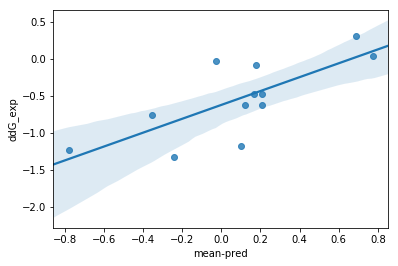

In [16]:
sns.regplot(pred_data_notna["mean-pred"],pred_data_notna["ddG_exp"])

In [45]:
np.square( pred_data_notna["mean-pred"] - pred_data_notna["ddG_exp"] ).sum()

6.123218092000492

In [46]:
np.square( pred_data_notna["ddG_exp"] - pred_data_notna["ddG_exp"].mean() ).sum()

3.072966666666666

In [49]:
pred_data_notna["ddG_exp"] - pred_data_notna["ddG_exp"].mean()

3bdy.protein.H33M.Repair4.clean.pdb    0.571667
3bdy.protein.H33W.Repair4.clean.pdb    0.451667
3bdy.protein.H52R.Repair4.clean.pdb    0.841667
3bdy.protein.H98F.Repair4.clean.pdb   -0.638333
3bdy.protein.H98H.Repair4.clean.pdb   -0.078333
3bdy.protein.H98K.Repair4.clean.pdb   -0.088333
3bdy.protein.H98M.Repair4.clean.pdb   -0.788333
3bdy.protein.H98W.Repair4.clean.pdb   -0.688333
3bdy.protein.H98Y.Repair4.clean.pdb   -0.218333
3bdy.protein.H99D.Repair4.clean.pdb    0.061667
3bdy.protein.H99M.Repair4.clean.pdb    0.061667
3bdy.protein.H99R.Repair4.clean.pdb    0.511667
Name: ddG_exp, dtype: float64

In [48]:
pred_data_notna["mean-pred"] - pred_data_notna["ddG_exp"]

3bdy.protein.H33M.Repair4.clean.pdb    0.745551
3bdy.protein.H33W.Repair4.clean.pdb    0.269748
3bdy.protein.H52R.Repair4.clean.pdb    0.386773
3bdy.protein.H98F.Repair4.clean.pdb    1.283498
3bdy.protein.H98H.Repair4.clean.pdb    0.739415
3bdy.protein.H98K.Repair4.clean.pdb    0.839196
3bdy.protein.H98M.Repair4.clean.pdb    1.091360
3bdy.protein.H98W.Repair4.clean.pdb    0.451084
3bdy.protein.H98Y.Repair4.clean.pdb    0.405986
3bdy.protein.H99D.Repair4.clean.pdb    0.685851
3bdy.protein.H99M.Repair4.clean.pdb    0.645681
3bdy.protein.H99R.Repair4.clean.pdb    0.001043
dtype: float64

In [20]:
mcsm_result = pd.read_table("../data/3bdy_mcsm_results.txt")

In [21]:
mcsm_result["mutant"]= mcsm_result["CHAIN"].astype(str)+mcsm_result["RES_POS"].astype(str)+mcsm_result["MUT_RES"].astype(str)

In [22]:
mcsm_result = mcsm_result[["PRED_DDG","mutant"]]

In [23]:
pred_data_notna.reset_index()["index"].str.split(".",expand=True)[2]

0     H33M
1     H33W
2     H52R
3     H98F
4     H98H
5     H98K
6     H98M
7     H98W
8     H98Y
9     H99D
10    H99M
11    H99R
Name: 2, dtype: object

In [27]:
pred_data_notna["mutant"] = pred_data_notna.reset_index()["index"].str.split(".",expand=True)[2].values

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
pred_data_final = pred_data_notna.merge(mcsm_result,on="mutant")
pred_data_final.set_index("mutant",inplace=True)

In [34]:
r2_score(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"])

-4.830391261430324

In [35]:
np.sqrt(mean_squared_error(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"]))

1.221904183368456

In [43]:
pred_data_final.corr()

,z-score,ddG_exp,Lasso_pred,gbt_pred,svr_pred,poly_pred,mean-pred,PRED_DDG
z-score,1.000000,0.632829,0.599963,0.725922,0.789752,0.767015,0.796857,0.273251
ddG_exp,0.632829,1.000000,0.593768,0.590840,0.742423,0.743441,0.744191,0.304147
Lasso_pred,0.599963,0.593768,1.000000,0.691513,0.898484,0.904885,0.935401,-0.128070
gbt_pred,0.725922,0.590840,0.691513,1.000000,0.635781,0.653636,0.762217,0.322703
svr_pred,0.789752,0.742423,0.898484,0.635781,1.000000,0.987504,0.979628,-0.010538
poly_pred,0.767015,0.743441,0.904885,0.653636,0.987504,1.000000,0.984178,0.037263
mean-pred,0.796857,0.744191,0.935401,0.762217,0.979628,0.984178,1.000000,0.055056
PRED_DDG,0.273251,0.304147,-0.128070,0.322703,-0.010538,0.037263,0.055056,1.000000


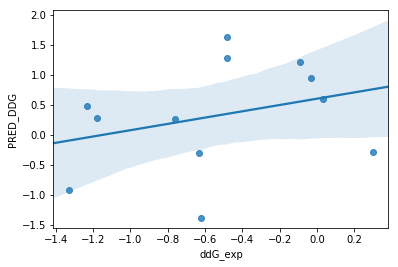

In [44]:
sns.regplot(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"])